# Longitudinal plane and instability simulation

In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import xtrack as xt
import xpart as xp

xt.enable_pyheadtail_interface()

PyHEADTAIL v1.16.5


### Import machine and twiss

In [3]:
# Import in Xsuite
line = xt.Line.from_json('./pimms_00_optics.json')
tw4d = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/98 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
line.discard_tracker()
line.append_element(name='aperture', element=xt.LimitRect(min_x=-0.05, max_x=0.05))

<Line  at 5989287952>

### Switch on the RF

In [5]:
line.vars['vrf'] = 0.01 # MV
line.vars['frf'] = 1 / tw4d.T_rev0 / 1e6 # MHz, h=1

In [6]:
# 6D twiss
tw = line.twiss()
tw.qs

0.001357006792701454

### Inspect longitudinal phase space

In [7]:
# Build a set of particles with different momenta
p = line.build_particles(delta=np.linspace(-1e-2, 1e-2, 41))

In [8]:
# Track
line.track(p, num_turns=2000, turn_by_turn_monitor=True, with_progress=True)

Tracking:   0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
mon = line.record_last_track

Text(0, 0.5, '$\\delta$ [10$^{-3}$]')

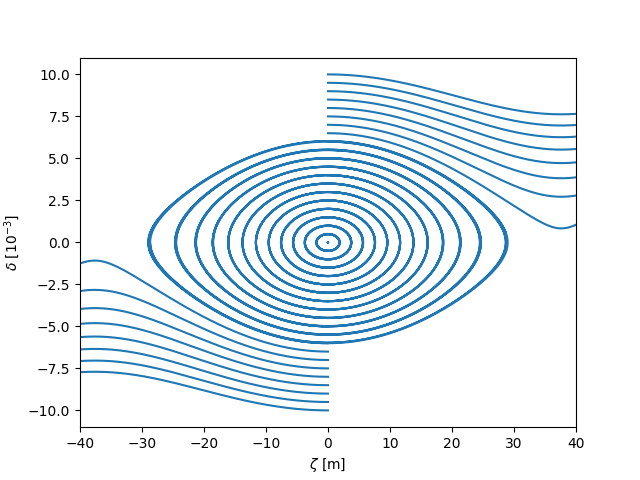

In [10]:
plt.figure()
plt.plot(mon.zeta.T, mon.delta.T*1e3, color='C0');
plt.xlim(-40, 40)
plt.xlabel(r'$\zeta$ [m]')
plt.ylabel(r'$\delta$ [10$^{-3}$]')

### Install PyHEADTAIL impedance in the Xsuite line

In [11]:
# Define PyHEADTAIL resonator wakefield
from PyHEADTAIL.impedances import wakes
from PyHEADTAIL.particles.slicing import UniformBinSlicer

R_shunt = 100e6        # Shunt impedance [Ohm/m]
frequency = 1.3e6      # Resonance frequency [Hz]
Q = 1                  # Quality factor

slices = 20
slicer_for_wakes = UniformBinSlicer(slices, n_sigma_z=6)

wake = wakes.CircularResonator(R_shunt, frequency, Q)
wakefield = wakes.WakeField(slicer_for_wakes, wake)
wakefield.needs_hidden_lost_particles = True

In [12]:
# Install impedance in the Xsuite ring
line.discard_tracker()
line.append_element(name='wakefield', element=wakefield)
line.build_tracker()

### Generate a bunch matched to the bucket and to the optics

In [13]:
bunch = xp.generate_matched_gaussian_bunch(line=line,num_particles=1000,
    total_intensity_particles=1e11, nemitt_x=2e-6, nemitt_y=2e-6, sigma_z=10.)
bunch.circumference = tw.circumference # required by PyHEADTAIL

bunch0 = bunch.copy() # Keep initial state

Ignoring collective elements in particles generation.


*** Maximum RMS bunch length 11.82730677406004m.
... distance to target bunch length: -1.0000e+01
... distance to target bunch length: 1.5294e+00
... distance to target bunch length: 1.4164e+00
... distance to target bunch length: -8.3951e-02
... distance to target bunch length: 1.3153e-01
... distance to target bunch length: 4.3249e-03
... distance to target bunch length: 1.3399e-04
... distance to target bunch length: -8.3374e-09
... distance to target bunch length: 2.0244e-05
--> Bunch length: 9.999999991662596


Ignoring collective elements in particles generation.


--> Emittance: 0.6118515379181246


### Simulate 1000 turns

In [14]:
# Initial kick of 1 mm
bunch.x += 1e-3

In [15]:
# Define quantities to be logged during tracking
def compute_x_mean(line, particles):
    bunch.hide_lost_particles()
    x_ave = np.mean(particles.x)
    bunch.unhide_lost_particles()
    return x_ave

def compute_intensity(line, particles):
    bunch.hide_lost_particles()
    inten = np.sum(particles.weight)
    bunch.unhide_lost_particles()
    return inten

track_log = xt.Log(x_mean=compute_x_mean, intensity=compute_intensity)

In [16]:
# Track!
line.enable_time_dependent_vars = True
line.track(bunch, log=track_log, num_turns=1000, with_progress=True)

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

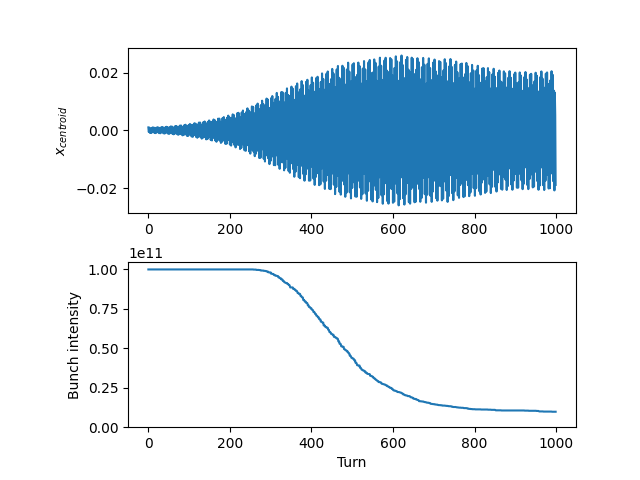

In [17]:
# Plot logged data
x_mean = line.log_last_track['x_mean']
intensity = line.log_last_track['intensity']

plt.figure()
ax1 = plt.subplot(2,1,1)
plt.ylabel(r'$x_{centroid}$')
plt.plot(x_mean)
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(intensity)
plt.ylim(bottom=0)
plt.ylabel('Bunch intensity')
plt.xlabel('Turn')

plt.subplots_adjust(left=0.2, hspace=0.3, top=0.9)

### Adjust the sextupoles to change the chromaticity

In [18]:
line.enable_time_dependent_vars = False
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['ksf', 'ksd'], step=1e-3),
    targets=xt.TargetSet(dqx=-2., dqy=-2., tol=1e-3, tag="chrom")
)
opt.solve()

The line has collective elements.
In the twiss computation collective elements are replaced by drifts
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
                                             
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Optimize - start penalty: 2.687                             
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
The line has collective elements. = 2.6870e+00              
In the twiss computation collective elements are replaced by drifts
The line has collective elements. = 2.6864e+00              
In the twiss computation collective elements are replaced by drifts
The line has collective

### Repeat the simulation

In [19]:
bunch = bunch0.copy()
bunch.circumference = tw.circumference

In [20]:
bunch.x += 1e-3
line.enable_time_dependent_vars = True
line.track(bunch, log=track_log, num_turns=1000, with_progress=True)


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

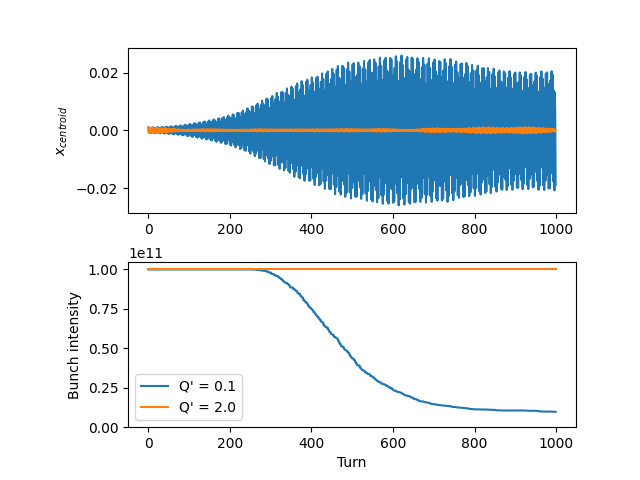

In [21]:
# Plot logged data
x_mean_high_chroma = line.log_last_track['x_mean']
intensity_high_chroma = line.log_last_track['intensity']

plt.figure()
ax1 = plt.subplot(2,1,1)
plt.ylabel(r'$x_{centroid}$')
plt.plot(x_mean, label="Q' = -0.1")
plt.plot(x_mean_high_chroma, label="Q' = -2.0")
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(intensity, label="Q' = -0.1")
plt.plot(intensity_high_chroma, label="Q' = -2.0")
plt.ylim(bottom=0)
plt.ylabel('Bunch intensity')
plt.xlabel('Turn')
plt.legend()

plt.subplots_adjust(left=0.2, hspace=0.3, top=0.9)